# MNIST Image Classification

## Introduction

I'm going to start with MNIST, because it's a dataset that I'm
massively familiar with that. On top of that, it has a continuous
distribution, so once I get comfortable with implementing a simple
convolutional neural network, I'll develop an auto encoder, and a 
variational auto encoder. 

For this example, we will do a simple convolutional neural network
in torch.

## TorchVision

The [torchvision](https://pytorch.org/docs/stable/torchvision/index.html) 
package contains utilities for many tasks in computer vision. 
These include transformations, loading toy data sets, and popular model
architectures. In this tutorial, I don't intend to use the last. I'll just 
[load](http://127.0.0.1:8888/?token=755449bfdb2fd6b486d94057b9759d4c877749c8b9a71482)
MNIST (a popular dataset of images of numbers) and play about with it. 

In addition, we will start by just training the model without transformations. While
this tutorial focuses on models in torch, it should be fun to see how transforms impact
MNIST. Up front, I'll hypothesize that any gains will be very much marginal. The MNIST
data set is pretty free of noise when preprocessed properly. Worth noting, there are 
plenty of datasets to play with, including QMNIST, which is not processed. 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import numpy as np
import matplotlib.pyplot as plt

## Loading and Preprocessing

As noted, we won't do any elaborate preprocessing. Instead, we just load the data
and normalize.

The image datasets are loaded as PILImages. We need to load these as tensors, and
normalize them. For this, we can apply `transformation`s from `torchvision`.
These 
[transforms](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision-transforms)
are similar to the sklearn transforms, but are specifically for images. There is
also a funcitonal module that allows for more custom control. 

Users can call the `Compose()` method to build pipelines of transformations. We 
will just be casting the images to tensors, then centering the data ourselves. 
This way, we don't have to make any underlying assumptions about the distribution 
of the data. Worth noting that `Normalize` always expects an iterable. If you need
to normalize single channel images, you must pass an iterable with one element. 

Note that mnist comes with a single (gray) channel of 28x28 pixels.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])
trainset = MNIST(
    root='./data/', train=True, 
    download=True, transform=transform
)

As we can see, it's possible to add transforms to a datasets transforms after the
dataset has been constructed. This follows logically from how `Compose` is created.
The `Compose` class is [defined](https://github.com/pytorch/vision/blob/19315e313511fead3597e23075552255d07fcb2a/torchvision/transforms/transforms.py#L43)
with:

```
def __init__(self, transforms: list):
    '''
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    '''
    self.transforms = transforms
```

Because of this, we are free to append transformations to this object. The trainset
that uses this will reference that object. 

So, in this case, we compute the mean and standard deviation so we can normalize the
images with the parameters that define their distribution. We then `append` the 
created transformation to the list. 

In [3]:
mu = trainset.data.float().mean() / 255
sigma = trainset.data.float().std() / 255

transform.transforms.append(
    transforms.Normalize(
        mean=(mu,), std=(sigma,)
    )
)

In [4]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(tensor(0.1307),), std=(tensor(0.3081),))
           )

The `DataLoader` class is used to . . . well . . . load data. And it's
pretty freakin' swell. First, it is multithreaded, and you can specify
the worker count. That's really very brilliant, and much simpler (and
more elegant) than the paradigm of using generators. 

The `__init__` 
[method](https://github.com/pytorch/pytorch/blob/10c456417ce49cb5bfad8aba2bd7e3a23a83aef2/torch/utils/data/dataloader.py#L120) 
takes in many arguments, but one is the dataset, in this case `trainset`.
We can then create a python iterator over that dataset. All of the
transformations will happen from the `transforms` in the dataset. That is,
the dataset handles applying the transform when you call 
`__getitem__(self, idx)`.

In [5]:
BATCH_SIZE = 64
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=2
)
targets = np.array([x for x in range(10)])

In [6]:
dataiter = iter(trainloader)
im, lab = dataiter.next()

im.size()

torch.Size([64, 1, 28, 28])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


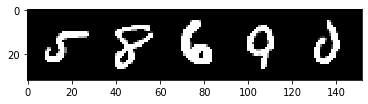

5 8 6 9 0


In [7]:
SHOW_COUNT = 5
%matplotlib inline
def image_show(image):
    np_image = image.numpy()
    plt.imshow(np.transpose(np_image, (1, 2, 0)))
    plt.show()
    
image_show(
    torchvision.utils.make_grid(im[0:SHOW_COUNT, :, :, :])
)
print(' '.join(str(d) for d in targets[lab[:SHOW_COUNT]]))

Worth testing at this point is whether adding a transformation will affect 
the data loader. Based on reading the source, the dataset in the data loader
is just a reference. So, if we add a transform, the dataloader will just load
data with the transform applied.

This does, in fact, work. In addition, it appears that the transforms are
applied in the order of the list. So, we have to call `insert` to append to
the front of the list.

Details on the `RandomRotation` transform 
[here](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomRotation).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


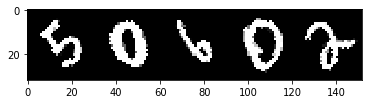

In [8]:
transform.transforms.insert(
    0, transforms.RandomRotation(degrees=(45, 90))
)
# Get a new iterator
dataiter = iter(trainloader)
im, lab = dataiter.next()

image_show(
    torchvision.utils.make_grid(im[0:SHOW_COUNT, :, :, :])
)

Before moving on, let's reset the transforms.

In [ ]:
transform.transforms.

## Network Topology

Now that we've gotten sufficiently side tracked with transforms, let's
start making and training a model. 